# Mono-internVL
![mono](monointernvl.png)

### How to run?

1. Create environment with python 3.10 (What I am using)
2. Intall torch and torchvision (with cuda support to run model inference on GPU) [Pytorch](https://pytorch.org/)
3. run `pip install -r requirements.txt`

You're good to go!

In [1]:
import re
import numpy as np
from PIL import Image
from pprint import pprint
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from IPython.display import Markdown, display, Latex

import torch
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig

In [2]:
# Define mean and standard deviation values for ImageNet normalization
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

In [3]:
def build_transform(input_size):
    """
    Build a transform that resizes the image to the given size and normalizes it
    to the range [-1, 1] using the ImageNet mean and standard deviation.

    Args:
        input_size (int): The size to resize the image to.

    Returns:
        A callable that takes in an image and applies the specified transform.
    """
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),  # Ensure image is in RGB mode
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),  # Resize to target size
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)  # Normalize using ImageNet mean and std
    ])
    return transform

In [4]:
def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    """
    Find the closest aspect ratio to the given aspect ratio in the list of target_ratios.

    Args:
        aspect_ratio (float): The aspect ratio to find the closest match to.
        target_ratios (list): A list of tuples containing the target aspect ratios.
        width (int): The width of the original image.
        height (int): The height of the original image.
        image_size (int): The size of the image to resize to.

    Returns:
        A tuple containing the aspect ratio that is closest to the given aspect ratio.
    """
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    # Iterate through each ratio, finding the closest match
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

In [5]:
def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    """
    Dynamically preprocess an image by splitting it into tiles of size (image_size, image_size)
    and optionally adding a thumbnail of size (image_size, image_size).

    Args:
        image (PIL.Image): The image to preprocess.
        min_num (int, optional): The minimum number of tiles to split the image into. Defaults to 1.
        max_num (int, optional): The maximum number of tiles to split the image into. Defaults to 12.
        image_size (int, optional): The size of the tiles to split the image into. Defaults to 448.
        use_thumbnail (bool, optional): Whether to add a thumbnail of size (image_size, image_size) to the end of the list of
            tiles. Defaults to False.

    Returns:
        A list of PIL.Image objects, where each object is a tile of size (image_size, image_size) or a thumbnail of size
            (image_size, image_size) if use_thumbnail is True.
    """
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

In [6]:
def load_image(image_file, input_size=448, max_num=12):
    """
    Loads and processes an image from a file.

    Args:
        image_file (str): The path to the image file to be loaded.
        input_size (int, optional): The size to which the image will be resized. Defaults to 448.
        max_num (int, optional): The maximum number of image tiles to process. Defaults to 12.

    Returns:
        torch.Tensor: A tensor containing the processed pixel values of the image.
    """
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [7]:
path = 'OpenGVLab/Mono-InternVL-2B'
quantization_config = BitsAndBytesConfig(load_in_8bit=True)  # You can also use load_in_4bit=True
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    quantization_config=quantization_config,
    trust_remote_code=True).eval()
tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)

c:\Users\mlwit\.conda\envs\internvl\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\mlwit\.conda\envs\internvl\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
generation_config = dict(max_new_tokens=1024, do_sample=True)

### Just text

In [9]:
# pure-text conversation
question = 'Hello, who are you?'
with torch.no_grad():
    response, history = model.chat(tokenizer, None, question, generation_config, history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

c:\Users\mlwit\.conda\envs\internvl\lib\site-packages\bitsandbytes\autograd\_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


User: Hello, who are you?
Assistant: Hello! I am an AI assistant whose name is InternVL, developed jointly by Shanghai AI Lab and SenseTime.


### Image captioning and OCR

In [11]:
# set the max number of tiles in `max_num`
pixel_values = load_image('./demo_images/pami.png', max_num=12).to(torch.bfloat16).cuda()

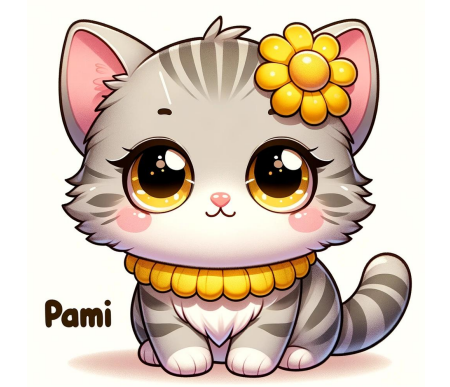

In [12]:
image = Image.open('./demo_images/pami.png')
display(image)

In [13]:
# Image captioning
question = '<image>\nPlease describe the image shortly.'
response = model.chat(tokenizer, pixel_values, question, generation_config)
pprint(f'User: {question}\nAssistant: {response}')

('User: <image>\n'
 'Please describe the image shortly.\n'
 'Assistant: The image shows a cute cartoon character styled like a cat. The '
 'background and the details of the character are simplified and stylized.')


In [14]:
# Image captioning
question = '<image>\nPlease describe the image in details.'
response = model.chat(tokenizer, pixel_values, question, generation_config)
pprint(f'User: {question}\nAssistant: {response}')

('User: <image>\n'
 'Please describe the image in details.\n'
 'Assistant: This image features a cartoon cat illustration that is labeled '
 '"Pami." The cat has a striking appearance with a light-colored fur that '
 "resembles an artist's sketch.\n"
 '\n'
 'Key aspects of the image include:\n'
 '\n'
 "1. **Face and Eyes:** The cat's face has large, expressive eyes with "
 'prominent and sparkling light bead-like pupils. The eyes are set on its '
 'head, making them look lively and endearing. They reflect the light, giving '
 'them a glossy appearance.\n'
 '\n'
 "2. **Nose and Mouth:** Despite the exaggerated expression, the cat's mouth "
 'looks soft and delicate, painted in blush colors near its cheeks. It appears '
 'to be blushing as it looks directly at the viewer, adding a cute and '
 'innocent vibe to its expression.\n'
 '\n'
 '3. **Hair:** The cat has large, prominent yellow ears, with white tips, '
 'giving it an adorable and endearing appearance. A flower is placed on top of 

In [15]:
pixel_values = load_image('./demo_images/Nobel prize.png', max_num=12).to(torch.bfloat16).cuda()

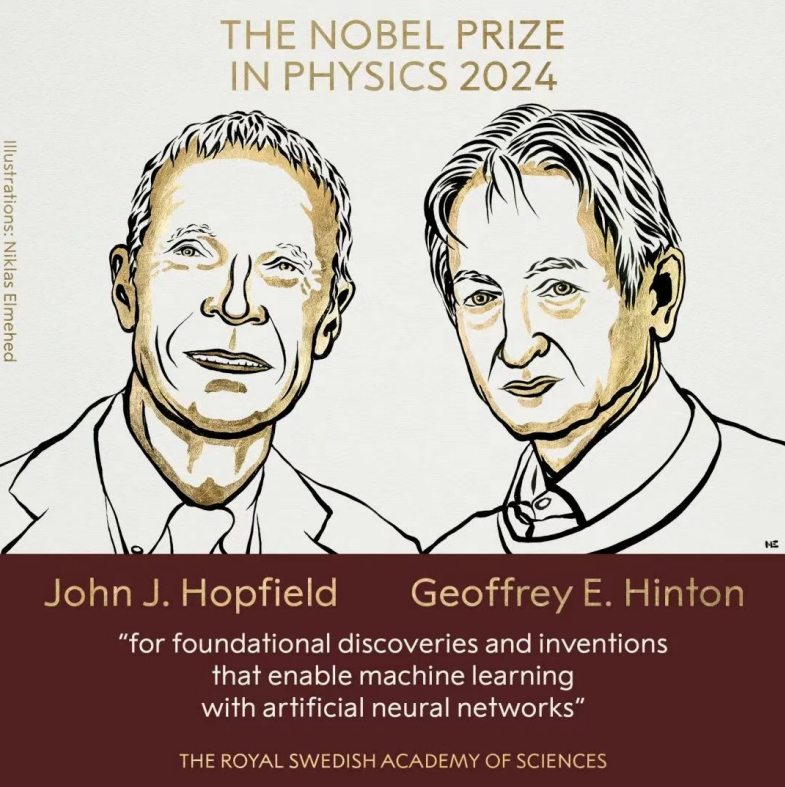

In [16]:
image = Image.open('./demo_images/Nobel prize.png')
display(image)

In [18]:
# Image captioning & OCR with multi-round question-answer conversation
question = '<image>\nWhat is the content in this picture?'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=None, return_history=True)
pprint(f'User: {question}\nAssistant: {response}')

('User: <image>\n'
 'What is the content in this picture?\n'
 'Assistant: The image is an illustration of two individuals, portrayed in a '
 'vintage style with limited color and line art. Above the illustration, text '
 'reads "THE NOBEL PRIZE IN PHYSICS 2024." Below the illustration, there is a '
 'quote from John J. Hopfield: "for foundational discoveries and inventions '
 'that enable machine learning with artificial neural networks." This quote is '
 'attributed to The Royal Swedish Academy of Sciences.')


In [19]:
# Second round
question = 'what"s the main color used in the image?'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')

User: what"s the main color used in the image?
Assistant: The main color used in the image is monochromatic with shades of tan and beige. However, the illustration style features a limited color palette.


### Object detection

In [1]:
pixel_values = load_image('./demo_images/cat.png', max_num=12).to(torch.bfloat16).cuda()

NameError: name 'load_image' is not defined

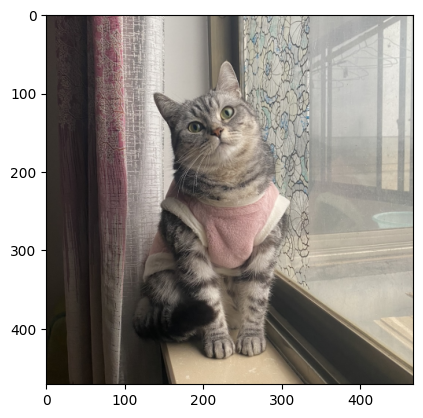

In [21]:
image = Image.open('./demo_images/cat.png')
plt.imshow(image)

In [22]:
# Image captioning
question = '<image>\nDetect the <ref>cat</ref> in the image with its bounding box.'
response = model.chat(tokenizer, pixel_values, question, generation_config)
pprint(f'User: {question}\nAssistant: {response}')

('User: <image>\n'
 'Detect the <ref>cat</ref> in the image with its bounding box.\n'
 'Assistant: cat[[220, 129, 706, 940]]')


In [2]:
# Regex pattern to capture the numbers inside the brackets
pattern = r"\[\[(\d+),\s*(\d+),\s*(\d+),\s*(\d+)\]\]"

# Search for the pattern in the text
match = re.search(pattern, response)

# coordinates
bbox = [int(match.group(i)) for i in range(1, 5)]

NameError: name 're' is not defined

In [24]:
x_center = (bbox[0] + bbox[2]) // 2
y_center = (bbox[1] + bbox[3]) // 2
width = bbox[2] - bbox[0]
height = bbox[3] - bbox[1]
print(x_center, y_center, width, height)

463 534 486 811


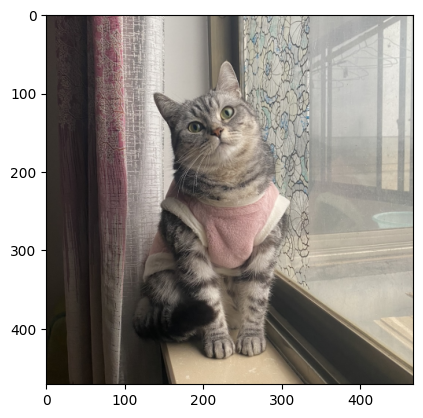

In [25]:
# Display the image
fig, ax = plt.subplots()
ax.imshow(image)

# Create a Rectangle patch
rect = patches.Rectangle((x_center, y_center), width, height, linewidth=2, edgecolor='red', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

# Show the image with the bounding box
plt.show()

### Code generation

In [26]:
pixel_values = load_image('./demo_images/math.png', max_num=12).to(torch.bfloat16).cuda()

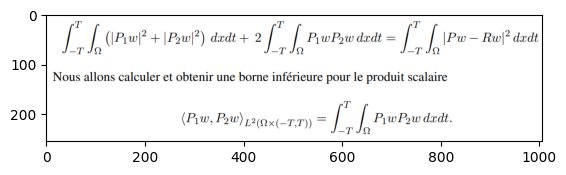

In [27]:
image = Image.open('./demo_images/math.png')
plt.imshow(image)

In [33]:
# Math formula extraction
question = '<image>\nConvert the formula in the figure to latex format.'
response = model.chat(tokenizer, pixel_values, question, generation_config)
pprint(f'User: {question}\nAssistant: {response}')

('User: <image>\n'
 'Convert the formula in the figure to latex format.\n'
 'Assistant: Absolutely! Below is the LaTeX representation of the formula '
 'provided in the figure:\n'
 '\n'
 '```latex\n'
 '\\int_{-T}^T \\int_{\\Omega} \\left(|P_1 w|^2 + |P_2 w|^2\\right) \\, dx dt '
 '+\n'
 '2 \\int_{-T}^T \\int_{\\Omega} P_1 w P_2 w \\, dx dt =\n'
 '\\int_{-T}^T \\int_{\\Omega} |P w - R w|^2 \\, dx dt\n'
 '```\n'
 '\n'
 'This LaTeX code will produce the same formula as shown in the figure in the '
 'context of LaTeX format. It includes all the required elements: the '
 'integrand, the integrals against the squared absolute values of the momenta, '
 'and the summations over the intervals of the integrals. The equations are '
 'also fully denoted for clarity.')


In [34]:
display(Markdown(response))

Absolutely! Below is the LaTeX representation of the formula provided in the figure:

```latex
\int_{-T}^T \int_{\Omega} \left(|P_1 w|^2 + |P_2 w|^2\right) \, dx dt +
2 \int_{-T}^T \int_{\Omega} P_1 w P_2 w \, dx dt =
\int_{-T}^T \int_{\Omega} |P w - R w|^2 \, dx dt
```

This LaTeX code will produce the same formula as shown in the figure in the context of LaTeX format. It includes all the required elements: the integrand, the integrals against the squared absolute values of the momenta, and the summations over the intervals of the integrals. The equations are also fully denoted for clarity.

In [35]:
# replace \ by \\ in \left\rangle and \times to render correctly

markdown_text = """
$$
\int_{-T}^T \int_{\Omega} \left(|P_1 w|^2 + |P_2 w|^2\\right) \, dx dt +
2 \int_{-T}^T \int_{\Omega} P_1 w P_2 w \, dx dt =
\int_{-T}^T \int_{\Omega} |P w - R w|^2 \, dx dt
$$
"""

display(Markdown(markdown_text))


$$
\int_{-T}^T \int_{\Omega} \left(|P_1 w|^2 + |P_2 w|^2\right) \, dx dt +
2 \int_{-T}^T \int_{\Omega} P_1 w P_2 w \, dx dt =
\int_{-T}^T \int_{\Omega} |P w - R w|^2 \, dx dt
$$


### Simple math reasoning

In [36]:
pixel_values = load_image('./demo_images/math reasoning.png', max_num=12).to(torch.bfloat16).cuda()

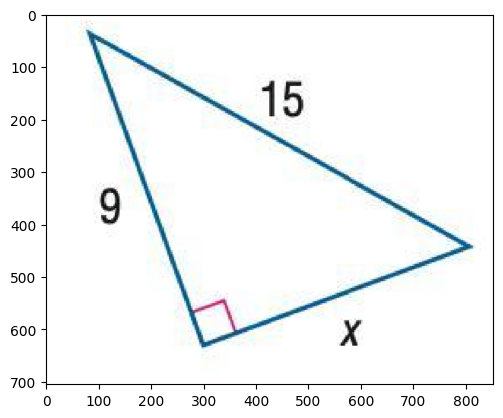

In [37]:
image = Image.open('./demo_images/math reasoning.png')
plt.imshow(image)

In [38]:
# Math reasoning
question = '<image>\nThe figure shows a right-angled triangle. What is the value of x?'
response = model.chat(tokenizer, pixel_values, question, generation_config)
pprint(f'User: {question}\nAssistant: {response}')

('User: <image>\n'
 'The figure shows a right-angled triangle. What is the value of x?\n'
 'Assistant: To find the value of \\(x\\), we can use the Pythagorean theorem, '
 'which states that in a right-angled triangle, the square of the length of '
 'one of the legs is equal to the square of the length of the hypotenuse. We '
 'can set up the equation as follows:\n'
 '\n'
 '\\[ a^2 + b^2 = c^2 \\]\n'
 '\n'
 'where \\(a\\) and \\(b\\) are the legs, and \\(c\\) is the hypotenuse. In '
 "this case, \\(a\\) and \\(b\\) are \\(9\\) and \\(x\\), respectively. Let's "
 'substitute these values into the equation:\n'
 '\n'
 '\\[ 9^2 + x^2 = c^2 \\]\n'
 '\n'
 '\\[ 81 + x^2 = m^2 \\]\n'
 '\n'
 'Where \\(m\\) is the hypotenuse.\n'
 '\n'
 'Now, we note the triangle with legs of length \\(9\\) and \\(15 - x\\):\n'
 '\n'
 '\\[ m = 15 \\]\n'
 '\n'
 'Substituting \\(m\\) into the equation, we get:\n'
 '\n'
 '\\[ 81 + x^2 = (15)^2 \\]\n'
 '\n'
 '\\[ 81 + x^2 = 225 \\]\n'
 '\n'
 'Subtract 81 from both si

In [39]:
display(Markdown(response))

To find the value of \(x\), we can use the Pythagorean theorem, which states that in a right-angled triangle, the square of the length of one of the legs is equal to the square of the length of the hypotenuse. We can set up the equation as follows:

\[ a^2 + b^2 = c^2 \]

where \(a\) and \(b\) are the legs, and \(c\) is the hypotenuse. In this case, \(a\) and \(b\) are \(9\) and \(x\), respectively. Let's substitute these values into the equation:

\[ 9^2 + x^2 = c^2 \]

\[ 81 + x^2 = m^2 \]

Where \(m\) is the hypotenuse.

Now, we note the triangle with legs of length \(9\) and \(15 - x\):

\[ m = 15 \]

Substituting \(m\) into the equation, we get:

\[ 81 + x^2 = (15)^2 \]

\[ 81 + x^2 = 225 \]

Subtract 81 from both sides:

\[ x^2 = 144 \]

Taking the square root of both sides:

\[ x = \sqrt{144} \]

\[ x = 12 \]

So, the value of \(x\) is 12.